In [308]:
%matplotlib inline

In [309]:
import numpy as np
import math
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt

In [310]:
f__0 = 0
f__T = 2 * np.pi + 0.5

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x - np.pi)
    if np.pi <= x <= 2 * np.pi + 0.5:
        return np.sin(x - np.pi - 0.5)

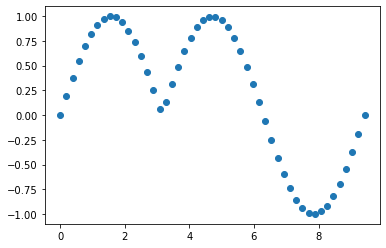

In [311]:
f__0 = 0
f__T = 3 * np.pi

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x)
    if np.pi <= x <= 3 * np.pi:
        return np.sin(x - np.pi)

mesh = np.linspace(f__0, f__T, 50, dtype='float64')
values = [f(knot) for knot in mesh]
plt.scatter(mesh, values)

In [312]:
def interpolate(knots, values):
    # Wyznacza listę wielomianów bazowych Lagrange'a dla podanych węzłów interpolacji.
    base = []
    inx = list(range(len(knots)))
    for k in inx:
        zeros = np.take(knots, inx[:k] + inx[k+1:])
        multipier = 1 / (knots[k] - zeros).prod()
        polynomial = Polynomial.fromroots(zeros) * multipier
        base.append(polynomial)

    # Wyznacza wielomian
    polynomial = Polynomial([0.])
    for k in range(len(knots)):
        polynomial += values[k] * base[k]
    return polynomial

In [313]:
def A_test(f, a0, a1, b1, b0, r, rho):
    knots = np.linspace(b1, b0, r+1, endpoint=True)
    values = np.array([f(x) for x in knots])
    w1 = interpolate(knots, values)
    
    knots = np.linspace(a1, a0, r+1, endpoint=True)
    values = np.array([f(x) for x in knots])
    w2 = interpolate(knots, values)
    
    z = np.linspace(a1, b1, r+1, endpoint=True)
    temp = (b0 - a0) ** (r + rho)

    values = np.array([np.abs(w1(z_i) - w2(z_i)) for z_i in z]) / temp
    return np.max(values)

In [314]:
def step1(g, c, delta, r, rho):
    max_diam = np.max([c[i+1] - c[i] for i in range(len(c)-1)])
    if max_diam <= 4 * delta:
        return 0, 0
    else:
        largest_result = 0
        second_largest_result = 0
        lagrest_result_index = 0
        for i in range(len(c)-1):
            if c[i+1] - c[i] > 4 * delta:
                test_result = A_test(g, c[i], c[i] + delta, c[i+1] - delta, c[i+1], r, rho)
                print("i: {}   c[i]: {}   test_result: {}".format(i, c[i], test_result))
                if test_result > largest_result:
                    largest_result = test_result
                    lagrest_result_index = i
                elif test_result > second_largest_result:
                    second_largest_result = test_result
        
        if math.isclose(largest_result, second_largest_result, rel_tol=1e-14):
            return 0, 0

    return c[lagrest_result_index], c[lagrest_result_index+1]

In [315]:
def step2(g, a, b, delta, r, rho): # bisection
    if a == 0 and b == 0:
        return []
    a_new, b_new = a, b
    B = [a, b]

    while True:
        if b_new - a_new <= 4 * delta:
            print("HERE1")
            return B
        
        v = (a_new + b_new) / 2
        A1 = A_test(g, a_new, a_new +  delta, v - delta, v, r, rho)
        A2 = A_test(g, v, v +  delta, b_new - delta, b_new, r, rho)
        B.append(v)

        if math.isclose(A1, A2, rel_tol=1e-14):  # TODO: it should depend on precision
            print("HERE2")
            return B
        elif A1 > A2:
            b_new = v    
        else:
            a_new = v

In [316]:
def step3(g, c, B, delta):
    M = np.concatenate((c, B))
    M = np.sort(M)

    def adaptive_approximate(t):
        # locate knot that smaller or equal to t (and it is closest to t)
        for i in range(len(M)-1):
            if t >= M[i]:
                continue
        
        is_smaller = lambda i: M[i+1] - M[i] <= 4 * delta

        print("i: {}".format(i))
        if t <= M[i+1] and is_smaller:
            print("HERE3")
            return g(M[i])
        if t < M[i] + delta and not is_smaller:
            print("HERE4")
            return g(M[i])
        if t > M[i] + delta and t < M[i+1] - delta and not is_smaller:
            print("HERE5")
            left, right = M[i] + delta, M[i+1] - delta
            knots = [left, right]
            values = [g(left), g(right)]
            polynomial = interpolate(knots, values)
            return polynomial(t)
        if t > M[i+1] - delta and t < M[i+1] and not is_smaller:
            print("HERE6")
            return g(M[i+1] - delta)
    return M, adaptive_approximate

In [317]:
def Alg2014(g, a, b, m, r, rho):
    '''
    g - funkcja, którą aproksymujemy
    r - regularność funkcji
    a, b - brzegi przedziału [a,b]
    m - początkowa gęstość siatki
    '''
    # Step 0 (inicjalizacja stałych itp.)
    h = (b - a) / m
    delta = h ** (r + rho)
    c = np.linspace(a, b, m+1, dtype='float64') # mamy m+1 wezlów postaci c[0], ... , c[m]

    # kroki algorytmu
    left, right = step1(g, c, delta, r, rho)
    print("left: {}, right {}".format(left, right))

    B = step2(g, left, right, delta, r, rho)
    print("B: {}".format(B))
    
    M, approx = step3(g, c, B, delta)
    print("M: {}".format(M))
    
    return M, approx


In [321]:
mesh, f_approximation = Alg2014(f, f__0, f__T, 100, 5, 0.5)

# function to calculate values of approximation function
def f_values(mesh, fun):
    return [fun(knot) for knot in mesh]

f_approximation(2.0)

# print("mesh: {}".format(mesh))
# print("values: {}".format(f_values(mesh, f_approximation)))

i: 0   c[i]: 0.0   test_result: 261997809350562.28
i: 1   c[i]: 0.09424777960769379   test_result: 3.388255001351844e+16
i: 2   c[i]: 0.18849555921538758   test_result: 7.8766365885245e+17
i: 3   c[i]: 0.28274333882308134   test_result: 1.0138946744906537e+19
i: 4   c[i]: 0.37699111843077515   test_result: 7.926380452897385e+18
i: 5   c[i]: 0.47123889803846897   test_result: 4.001163258614607e+19
i: 6   c[i]: 0.5654866776461627   test_result: 1.0362271279578312e+20
i: 7   c[i]: 0.6597344572538565   test_result: 7.94232732452273e+20
i: 8   c[i]: 0.7539822368615503   test_result: 1.096949969812964e+21
i: 9   c[i]: 0.8482300164692441   test_result: 2.1368145984288378e+20
i: 10   c[i]: 0.9424777960769379   test_result: 2.4202494416010944e+21
i: 11   c[i]: 1.0367255756846316   test_result: 1.0836984139215328e+21
i: 12   c[i]: 1.1309733552923253   test_result: 3.173974007103574e+21
i: 13   c[i]: 1.2252211349000193   test_result: 1.7854218705420094e+22
i: 14   c[i]: 1.319468914507713   test_r

-0.0941083133185158

In [319]:
print(mesh)
print(f_values(mesh, f_approximation))

[0.         0.4712389  0.9424778  1.41371669 1.88495559 2.35619449
 2.82743339 3.29867229 3.76991118 4.24115008 4.71238898 5.18362788
 5.65486678 6.12610567 6.59734457 7.06858347 7.53982237 8.01106127
 8.01106127 8.12887099 8.18777585 8.24668072 8.48230016 8.48230016
 8.95353906 9.42477796]
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
[-0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.4539904997395462, -0.45399049973954

i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3
i: 24
HERE3


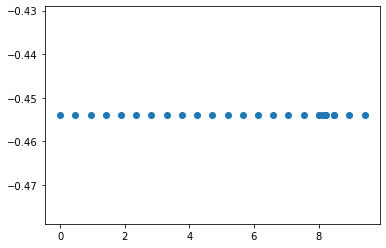

In [320]:
plt.scatter(mesh, f_values(mesh, f_approximation))